In [1]:
from tabu_search.algorithm import tabu_search, NeighborsTabuListInterface
import numpy as np
from typing import Collection, Dict, Any, Tuple, List

# Part 1

In [2]:
EDGES = 8
COSTS = [13, 7, 9, 1, 3, 19, 10, 7]
EDGE_MAPPING = {
    0: (1, 2),
    1: (1, 3),
    2: (1, 4),
    3: (2, 3),
    4: (3, 4),
    5: (2, 5),
    6: (3, 5),
    7: (4, 5),
}

In [3]:
def mst_cost(edges):
    base_cost = np.dot(COSTS, edges)
    penalty1 = 100 if edges[2] + edges[6] + edges[7] > 1 else 0
    penalty2 = 100 if edges[7] > edges[5] else 0
    return base_cost + penalty1 + penalty2


class MSTNeighborTabu(NeighborsTabuListInterface):
    def __init__(self, tenure: int, nbrs_size: int, args: Dict | None):
        super().__init__(tenure, nbrs_size, args)
        assert "cost" in args
        self.tabu_list = []
        self.cost = args["cost"]

    @staticmethod
    def cause_cycle(s: List) -> bool:
        visited = set()
        for i in range(len(s)):
            if s[i] > 0:
                visited.add(EDGE_MAPPING[i][0])
                visited.add(EDGE_MAPPING[i][1])
        return len(visited) < 5

    def neighbors(self, s_current: List) -> Tuple[Collection, Collection]:
        nbrs = []
        attrs = []

        def try_generate_neighbor():
            # picks an existing edge to flip, then list all unselected edges
            i1_try = np.random.choice([i for i in range(len(s_current)) if s_current[i] == 1])
            i2_candidates = [i for i in range(len(s_current)) if s_current[i] == 0]

            # for each unselected edge, we check if the swap causes a cycle or not
            for i2_candidate in i2_candidates:
                clone = s_current[:]

                # swaps edges
                clone[i1_try] = 0
                clone[i2_candidate] = 1

                # checks for cycle, if not then assign to i2
                if not self.cause_cycle(clone):
                    return i1_try, i2_candidate

            return None

        for _ in range(self.nbrs_size):
            # repeat the above part until assigned
            i1, i2 = try_generate_neighbor()
            while i1 is None and i2 is None:
                i1, i2 = try_generate_neighbor()

            copied = s_current[:]
            copied[i1] = 0
            copied[i2] = 1

            nbrs.append(copied)
            attrs.append(i2)

        return nbrs, attrs

    def add(self, attr: int):
        if len(self.tabu_list) >= self.tenure:
            self.tabu_list.pop(0)
        self.tabu_list.append(attr)

    def evaluate(self, s_current: Collection) -> float:
        return self.cost(s_current)

    def is_tabu(self, attr: Any):
        return attr in self.tabu_list


In [4]:
s0 = [1, 1, 1, 0, 0, 1, 0, 0]

res = tabu_search(mst_cost, s0, MSTNeighborTabu(3, 4, {"cost": mst_cost}), 100)
res.cost, res.solution

(21, [0, 1, 0, 1, 1, 0, 1, 0])

In [5]:
len(res.progress_current), len(res.progress_best)

(101, 101)

In [6]:
import seaborn as sns
import pandas as pd

<Axes: xlabel='Iteration'>

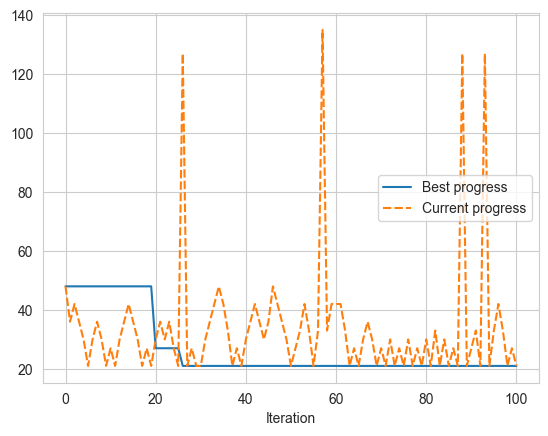

In [7]:
df = pd.DataFrame({
    "Iteration": np.arange(101),
    "Best progress": res.progress_best,
    "Current progress": res.progress_current,
})

sns.lineplot(df.set_index("Iteration"))

# Part 2